In [5]:
words = open("names.txt").read().splitlines()

In [ ]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

In [199]:
max(len(w) for w in words)

15

In [200]:
import torch
N = torch.zeros((27, 27), dtype=torch.int32)

In [201]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0  # this is a special character, usually <S> and <E> for start and end tokens, . here is both
itos = {i: s for s, i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [202]:
b = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

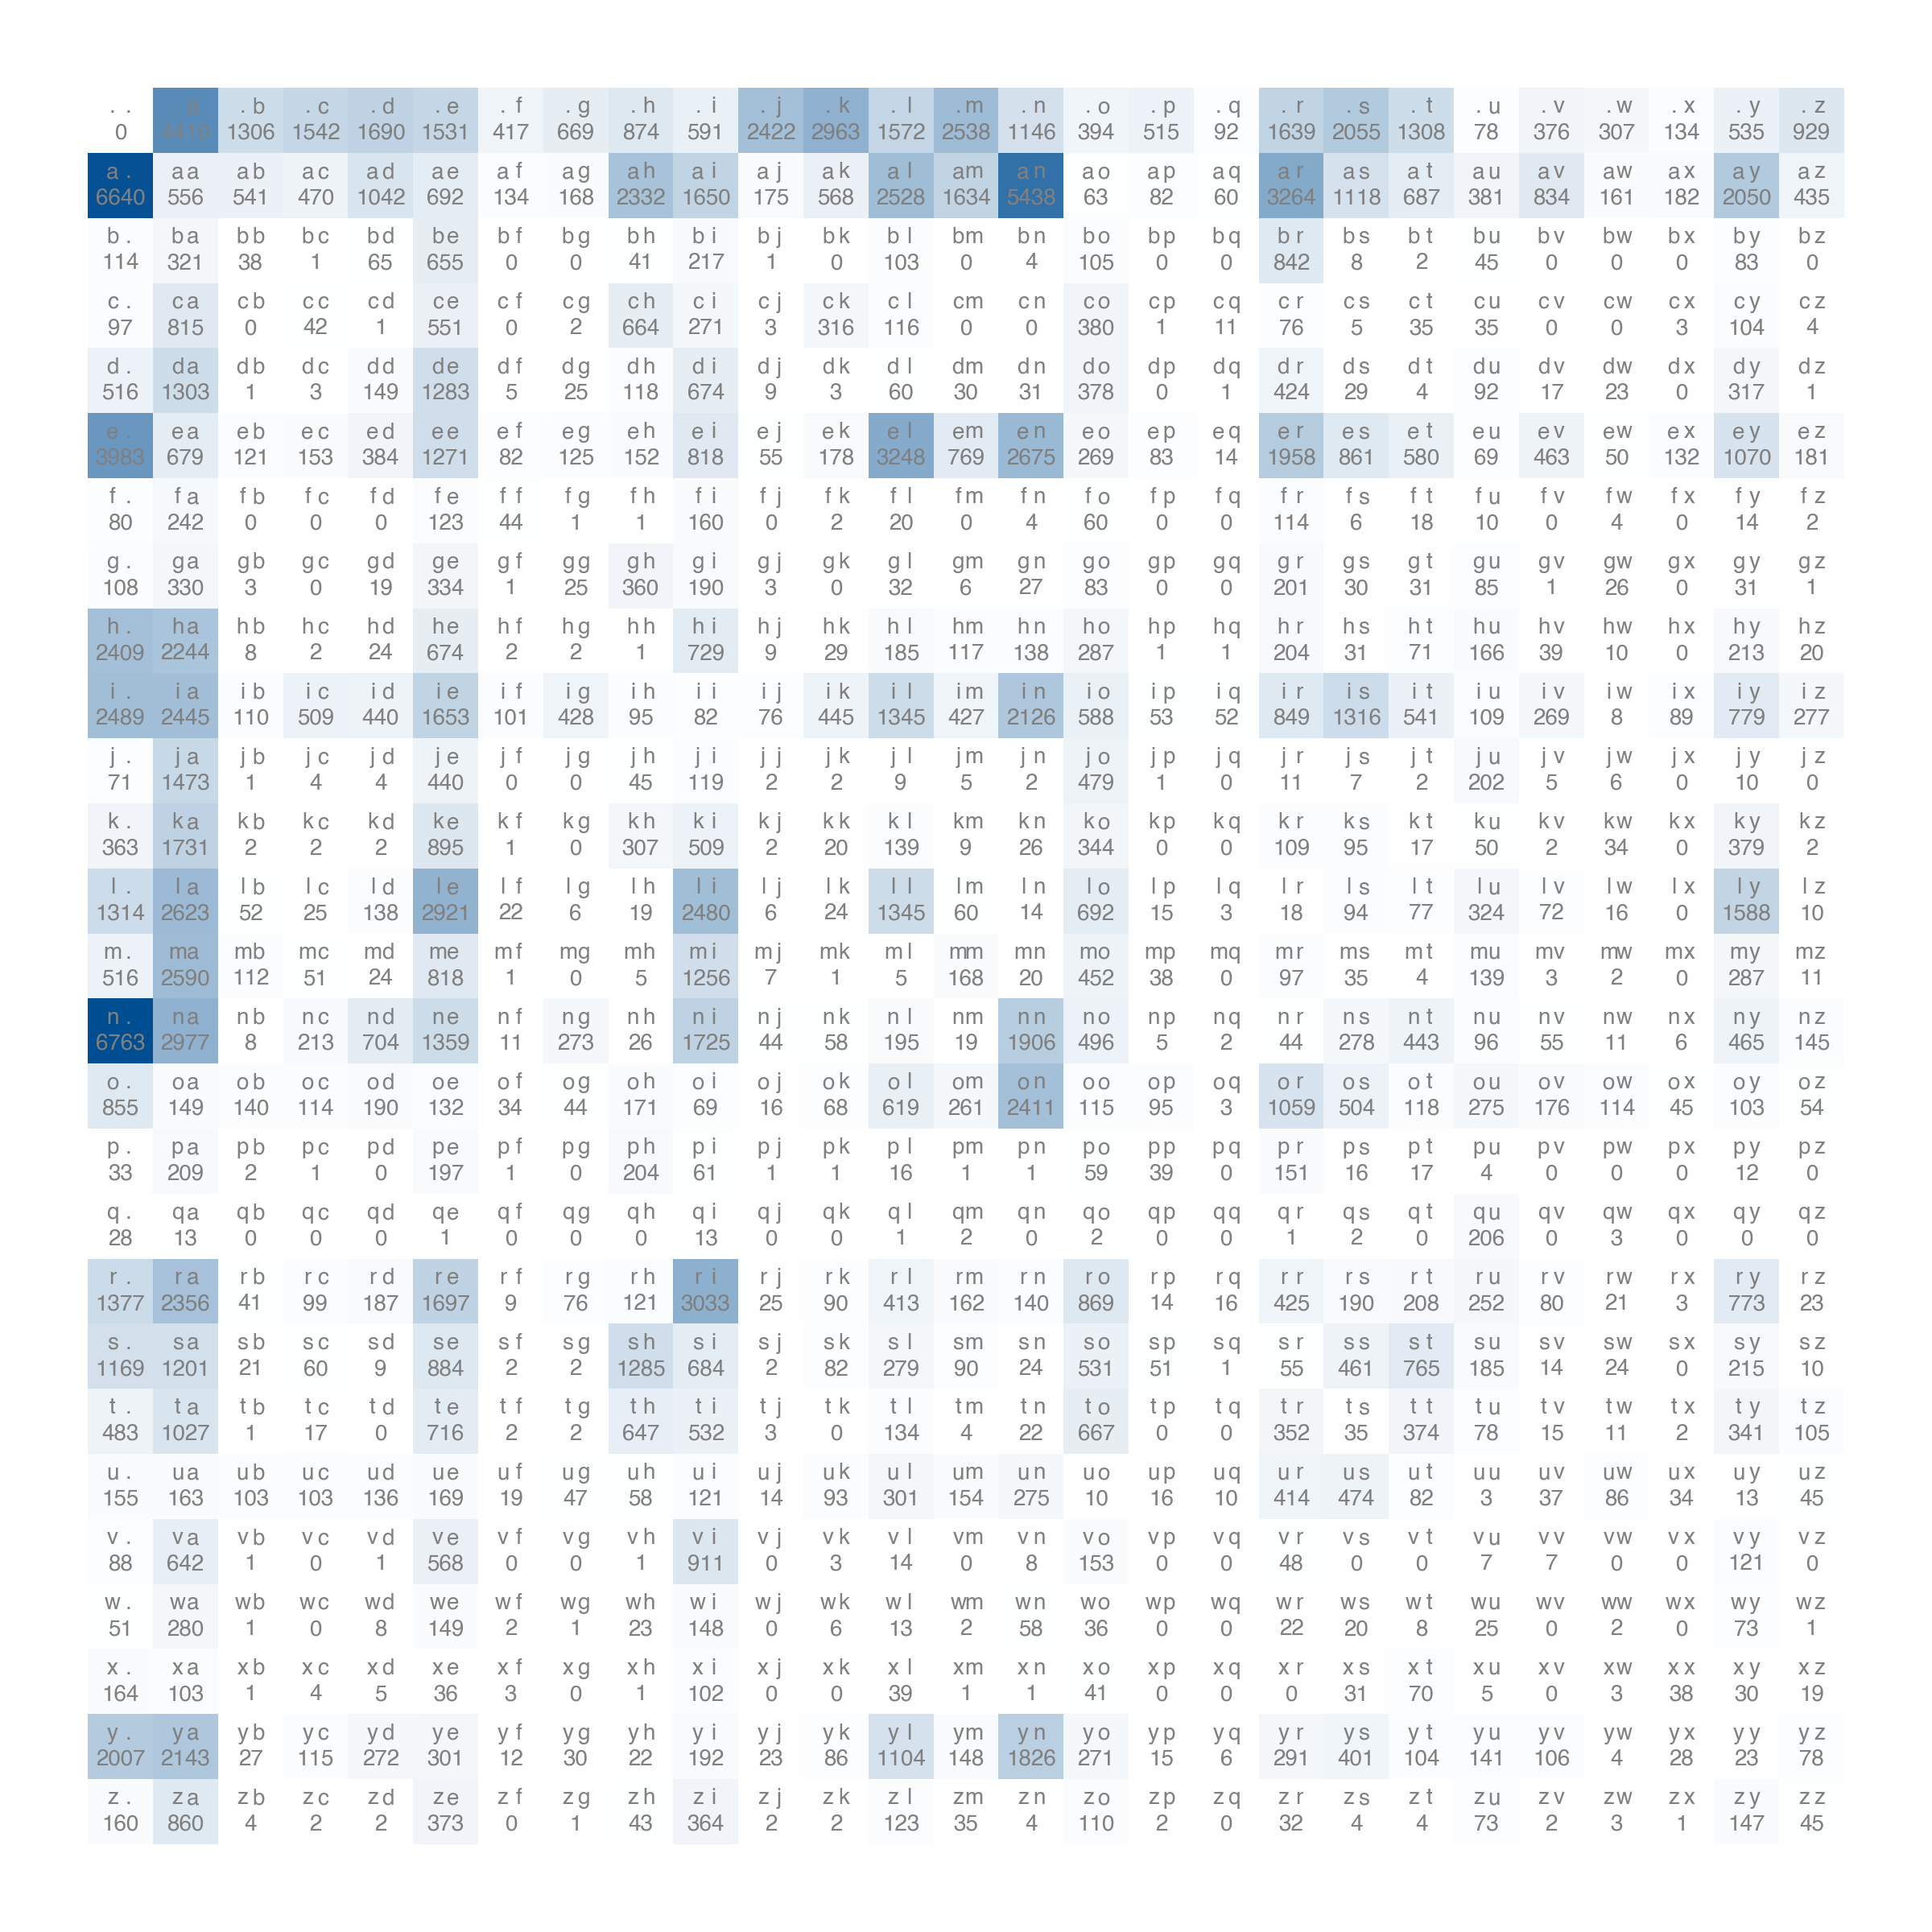

In [204]:
import polars as pl
from plotnine import *

def hm(N: torch.Tensor):
    df = (pl.DataFrame(N.numpy())
        .with_row_index("row")
        .unpivot(index="row", variable_name="col",
            value_name="value")
        .with_columns(pl.col("col").str.replace("column_","").cast(pl.Int32))
        .with_columns( pl.col("row").replace_strict(itos).alias("row_char"))
        .with_columns(pl.col("col").replace_strict(itos).alias("col_char"))
        .with_columns((27 - pl.col("row")).alias("row"))
    )

    p = (ggplot(df, aes('col', 'row', fill='value')) +
            geom_tile() +
            geom_text(aes(label='row_char'), nudge_y=0.2, nudge_x=-0.12, color='grey',
            size=10) +  # top
            geom_text(aes(label='col_char'), nudge_y=0.2, nudge_x =0.12, color='grey',
            size=10) +     
            geom_text(aes(label='value'), nudge_y=-0.2, color='grey',
            size=10) +      # bottom
            scale_fill_gradient(low='white', high='#004e92') +
            theme_void() +
            theme(figure_size=(12, 12), legend_position="none",
                    panel_background=element_blank(),
                    plot_background=element_blank()))
    return p
    
hm(N)


In [328]:
p = N[0].float() / sum(N[0])

In [ ]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [ ]:
g = torch.Generator().manual_seed(2442142)
p = torch.rand(3, generator=g)
p = p / p.sum()

p/p.sum()

tensor([0.4189, 0.5254, 0.0556])

In [291]:
torch.multinomial(p, 100, replacement=True, generator=g)

tensor([0, 2, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0])

**broadcasting rules**

1) align tensor dims from the **right**
2) iterating over dims, they have to be:
    * **equal**, or
    * one of them is **1**, or
    * one does **not exist**

3) **what happens if dims of `x` and `y` are not equal?** 
    * preprend 1 to the dims of tensor with fewer dims to make them equal 
    * for each dim size, resulting dim is the max of sizes of `x` and `y` along that dim

In [373]:
P = N.float()
P.sum(dim=1).shape

torch.Size([27])

In [ ]:
P = (N + 1).float() # model smoothing to not get infinity, -> no zeros in matrix P
P = P/P.sum(dim=1, keepdim=True)

In [408]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
        
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.


In [401]:
x = 4
print(f'{x=}')

x=4


q: how to summarise these numbers into a single metric to measure quality?

- likelihood: the product of all these probabilities (the higher the better)
- but: is a small number, hence: log(likelihood)
- then: log(a*b*c) = log(a) + log(b) + log(b)
- then: nll (we want to minimise loss)
- then: average, not sum (smaller number)

karpathy:
GOAL: maximize likelihodd of the data w.r.t. model parameters (stats modeling)
- equivalent to maximizing the log likelihood (because log is monotonic)
- equivalent to minimizing the negative log log_likelihood
- equivalent to minimizing the average negative log log_likelihood


In [413]:
x = torch.tensor(3)
x.dtype

torch.int64

In [409]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f}{logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


# NN approach

In [423]:
# create training set of bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
        

. e
e m
m m
m a
a .


In [ ]:
print(f"{xs=}")
print(f"{ys=}")


xs=tensor([ 0,  5, 13, 13,  1])
ys=tensor([ 5, 13, 13,  1,  0])


In [545]:
g = torch.Generator().manual_seed(21499421942)
W = torch.randn((27, 27), generator=g, requires_grad=True) # to map 27 inputs to 27 outputs

In [546]:
import torch.nn.functional as F

In [588]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # assume these are log-counts
counts = logits.exp() # counts, like N
probs = counts / counts.sum(dim=1, keepdim=True) # probs for the next characters
loss = -probs[torch.arange(5), ys].log().mean() # probs for the correct new character
print(loss.item())

3.8067314624786377


In [586]:
# backward pass
W.grad = None # set to zero, more efficient 
loss.backward()

In [587]:
W.data += -0.1 * W.grad

tensor(3.9844)